<a href="https://colab.research.google.com/github/JingwenLuo7/Machine-Learning-in-Bioinformatics-S25/blob/main/Project01_Spam_Classifier/Spam_project_subject_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam or Ham (project 1)

## 1- Introduction with the Bernoulli model


We say that a random variables $X \in \{0, 1\}$ follows a Bernoulli distribution of parameter $\theta$ if $\mathbb{P}(X = 1) = \theta$ and $\mathbb{P}(X = 0) = 1 − \theta$.


1.  Show that we can write the probability distribution of $X$ in a compact form as :
$$
\mathbb{P}(X = x) = \theta^{x} (1 − \theta)^{1−x}
$$

2. Suppose now that we have a set of n independent variables $x_1,...,x_n$. If we note $n_1 = \sum_{i=1}^n \mathbb{1}_{\{x_i=1\}}$ and $n_0 = n − n_1$, show that :
$$
\mathbb{P}(x_1,\ldots,x_n \mid \theta)=\theta^{n_1} (1−\theta)^{n_0}
$$

3. Show that the maximum likelihood estimator is $\hat{\theta}_{ML} = \frac{n_1}{n}$

4. A conjugate prior for the Bernoulli distribution is the Beta distribution.
$$
Beta(\theta \mid a, b) \propto \theta^{a−1} (1 − \theta)^{b−1}
$$
The Beta distribution has the following properties for its expectation and mode (for more details you can look in one of the books like the Bishop):
$$
\mathbb{E}(\theta) = \frac{a}{a+b} \text{, mode}(\theta) = \frac{a-1}{a+b-2}
$$

Show that with a $Beta(a,b)$ prior the posterior distribution
$\mathbb{P}(\theta \mid x_1,\ldots, x_n)$
is proportional to $\theta^{n_1+a-1} \cdot (1 − \theta)^{n_0+b-1}$

5. (Those two questions are optional, you can also simply use the result in the following)

  a. Show that the maximum a posteriori _mode_ estimate is in the form $\bar{\theta}_{MAP} = \frac{n_1+a-1}{n+a+b-2}$

  b. Show that the maximum a posteriori
_mean_ estimate is in the form $\hat{\theta}_{MAP} = \mathbb{E}(\theta \mid x_1,\ldots, x_n) =
\int_{\theta =0}^1 \mathbb{P}(\theta \mid x_1\ldots x_n) d\theta  = \frac{n_1+a}{n+a+b}$


## _write your answers to the questions here (you can also provide a scanned pdf of your answers with the notebook)_

## Spam classifier

The goal of this small project is to use a Naive bayes classifier to build a spam filter. To build our filter, we will use a dataset of 5,572 SMS messages put together by Tiago A. Almeida and José María Gómez Hidalgo.
The dataset and the article describing the dataset are in the whiteboard directory together with this notebook. Of note, the SMS messages have already been processed for ease of use: all punctuation marks have been removed and the text has been transformed into lowercase. It is also common practice to remove any stop words such as `a`, `as`, `the` and to perform stemming (reduce words to their base form, such as stripping  the final `s*` in plural words, or the `*ing` from verbs (e.g., running becomes run)). For the sake of simplicity, we did not do that in this exercise.

We will use a bag of word model:
 - We construct a corpus of the possible words $\mathcal{D} = \{w_1, \ldots , w_d\}$.
 - Each document is described by a vector of binary values $(x^{(1)}, \ldots , x^{(d)})$ where $x^{(i)} = 1$ if $w_i$ occurs in the document and $0$ otherwise.

The classification task is to predict for an SMS message if it is a _spam_ or a _ham_ (e.g. non-spam).

Our data is thus $\mathbf{x} = (x^{(1)},\ldots, x^{(d)})$, $x^{(i)} \in \{0,1\}$ and $y \in \{s,h\}$
We hypothesise that the values $x^{(i)}$ are drawn according to a Bernoulli distribution whose parameter depends on the class:
$$
\mathbb{P}(x^{(i)} \mid y = s) = \theta_{i,s}^{x^{(i)}} \cdot (1-\theta_{i,s})^{1-x^{(i)}}
$$
and
$$
\mathbb{P}(x^{(i)} \mid y = h) = \theta_{i,h}^{x^{(i)}} \cdot (1-\theta_{i,h})^{1-x^{(i)}}
$$
As we will use a naive Bayes classifier, the occurences of the different words are independent from each other.
\begin{align}
\mathbb{P}(\mathbf{x} \mid y = s) & = \prod_{i=1}^{d} \mathbb{P} (x^{(i)} \mid y = s)\\
  & =  \prod_{i=1}^{d} \theta_{i,s}^{x^{(i)}} \cdot (1-\theta_{i,s})^{1-x^{(i)}}
\end{align}


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing library and loading dataset

In [4]:
%matplotlib inline
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

##Load the dataset (if in the same directory as the notebook)
sms_data = np.loadtxt("/content/drive/MyDrive/ML/SMSSpamCollection_cleaned.csv", delimiter="\t", skiprows=1, dtype=str)

## create test data set for checkpointing
checkpoint_data = np.array([['spam', 'dear researcher submit manuscript money'],
          ['ham','dear friend meet beer'],
          ['ham', 'dear friend meet you']], dtype=str)

In [5]:
##Check the dataset
sms_data

array([['ham',
        'go until jurong point  crazy   available only in bugis n great world la e buffet    cine there got amore wat   '],
       ['ham', 'ok lar    joking wif u oni   '],
       ['spam',
        'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005  text fa to 87121 to receive entry question std txt rate t c s apply 08452810075over18 s'],
       ...,
       ['ham',
        'pity    was in mood for that  so   any other suggestions '],
       ['ham',
        'the guy did some bitching but i acted like i d be interested in buying something else next week and he gave it to us for free'],
       ['ham', 'rofl  its true to its name']], dtype='<U910')

In [7]:
##Check the size of the dataset
num_messages = sms_data.shape[0]
print(num_messages)

##third message is a...
print("Third message is a:", sms_data[2][0])
##dividing the third message into words
print(sms_data[2][1].split())

5572
Third message is a: spam
['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005', 'text', 'fa', 'to', '87121', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', '08452810075over18', 's']


## 2 - Construction of the Corpus

Construct the corpus $\mathcal{D}$ of all words in the dataset. The corpus will be represented as a hash table where each key is a unique word in the dataset and each value is the row index for that word.
 - How many unique words are there?
 - What are the 10 most common words (_e.g._ occuring in the most documents)?
 - Transform the set of messages in the form of a binary matrix of word occurrences.

 You can evaluate whether your implementation works using the checkpoint_data array. For this dataset the corpus could look as follows :

`{'dear': 0, 'researcher': 1, 'submit': 2, 'manuscript': 3, 'money': 4, 'friend': 5, 'meet': 6, 'beer': 7, 'you': 8}`
(of course you could have other index values for the words).

The recoding of the checkpoint data will give you the following numpy array:

```
[[1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 1.]]
```

In [8]:
def construct_corpus(data):
    """
    np.array[str, str] -> dict[str:int]

    from a 2D array of str, return a hash table
    """
    word_set = set()
    for _, message in data:
        words = message.split()
        word_set.update(words)

    corpus = {word: idx for idx, word in enumerate(sorted(word_set))}
    return corpus


In [9]:
def recode_messages(data, corpus):
    """
    np.array[str, str] * dict[str:int] -> np.array[int, int]

    returns the binary matrix encoding
    """
    num_messages = data.shape[0]
    vocab_size = len(corpus)
    binary_matrix = np.zeros((num_messages, vocab_size))

    for i, (_, message) in enumerate(data):
        words = set(message.split())  # avoid duplicate word counts
        for word in words:
            if word in corpus:
                idx = corpus[word]
                binary_matrix[i, idx] = 1
    return binary_matrix


D = construct_corpus(sms_data)

sms_matrix = recode_messages(sms_data, D)


In [11]:

##test

checkpoint_data = np.array([
    ['spam', 'dear researcher submit manuscript money'],
    ['ham',  'dear friend meet beer'],
    ['ham',  'dear friend meet you']
], dtype=str)

D_checkpoint = construct_corpus(checkpoint_data)
matrix_checkpoint = recode_messages(checkpoint_data, D_checkpoint)

print("Corpus:", D_checkpoint)
print("Binary Matrix:\n", matrix_checkpoint)



## check dataset
# 1. How many unique words are there?
num_unique_words = len(D)
print("1. Number of unique words:", num_unique_words)

# 2. What are the 10 most common words (e.g. occurring in the most documents)?
word_counts = Counter()
for message in sms_data[:, 1]:
    word_counts.update(message.split())

most_common_words = word_counts.most_common(10)
print("2. 10 most common words:", most_common_words)

# 3. Transform the set of messages in the form of a binary matrix of word occurrences.
print("3. Binary matrix shape:", sms_matrix.shape)
print(sms_matrix)

Corpus: {'beer': 0, 'dear': 1, 'friend': 2, 'manuscript': 3, 'meet': 4, 'money': 5, 'researcher': 6, 'submit': 7, 'you': 8}
Binary Matrix:
 [[0. 1. 0. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1.]]
1. Number of unique words: 8753
2. 10 most common words: [('i', 3021), ('to', 2253), ('you', 2245), ('a', 1450), ('the', 1339), ('u', 1207), ('and', 980), ('in', 903), ('is', 897), ('me', 807)]
3. Binary matrix shape: (5572, 8753)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 3 - Construct a training and a testing set and estimation of parameters


To do the evaluation of the model afterward we will split the dataset randomly in two:
- one dataset for training (80% of the messages)
- one dataset for testing (20% of the messages).

If you are familiar with it, you can use the `sklearn.model_selection` functions to construct the train and test datasets.


In [30]:
def train_test_split(X, Y, train_percentage=0.8):
    """
    Split X and Y into training and testing sets.

    Args:
        X: np.array, feature matrix (e.g., binary word matrix)
        Y: np.array, labels (e.g., 'spam' or 'ham')
        train_percentage: float, proportion of data to include in the training set

    Returns:
        X_train, X_test, Y_train, Y_test
    """
    assert X.shape[0] == Y.shape[0]

    number_examples = X.shape[0]
    num_train = int(train_percentage * number_examples)

    # Shuffle the indices
    indices = np.arange(number_examples)
    np.random.seed(42)
    np.random.shuffle(indices)

    # Split the data
    train_indices = indices[:num_train]
    test_indices = indices[num_train:]

    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]

    return X_train, X_test, Y_train, Y_test

# Split the data into training and testing sets
labels = sms_data[:, 0]
X_train, X_test, Y_train, Y_test = train_test_split(sms_matrix, labels)


## 4 - Estimation of the model parameters

We will now estimate our model on the training set. This means estimating two types of parameters: the class prior, and the conditional word occurence probabilities.

1.  Estimate the class prior $\mathbb{P}(c) = \mathbb{P}(y = c), (c = s, h)$
2.  Using the results from section 1, compute the Maximum a posteriori estimator for the $d \times 2$ matrix of parameters.
$$
\Theta = \left(
\begin{array}{cc}
\theta_{1,h}   & \theta_{1,s} \\
\theta_{2,h} & \theta_{2,s} \\
\vdots & \vdots \\
\theta_{d,h} & \theta_{d,s} \\
\end{array}
\right).
$$ You can use as conjugate prior a Beta(1, 1) distribution for instance (then $\theta_{i,c} = \frac{n_{i,c}+1}{N+2}$ where $n_{i,c}$ is the number of documents from the class $c$ where the word $w_i$ is present and $N$ is the total number of documents).

When applied to the checkpoint data, your $\Theta$ matrix should look like this:

```
# h    s
[[0.75 0.66666667]  #'dear'
 [0.25 0.66666667]  #'researcher'
 [0.25 0.66666667]  #'submit'
 [0.25 0.66666667]  #'manuscript'
 [0.25 0.66666667]  #'money'
 [0.75 0.33333333]  #'friend'
 [0.75 0.33333333]  #'meet'
 [0.5  0.33333333]  #'beer'
 [0.5  0.33333333]] #'you'
```

3. Represent the fitted class conditional densities $(\theta_{i,h})_{i \in \mathcal{D}}$ and $(\theta_{i,s})_{i \in \mathcal{D}}$ like on the corresponding slide of the course.


In [31]:
## Your code here for class priors
def estimate_class_priors(labels):
    """
    Estimate class prior probabilities.

    """
    counts = Counter(labels)
    total = len(labels)
    priors = {label: counts[label] / total for label in counts}
    return priors



def estimate_proportions(data_matrix, labels):
    """
    estimate the matrix theta

    """
    d = data_matrix.shape[1]
    theta = np.zeros((d, 2))

    for class_index, class_label in enumerate(['ham', 'spam']):
        # Get rows corresponding to this class
        class_rows = data_matrix[labels == class_label]

        # Number of documents for this class
        N_c = class_rows.shape[0]

        # Count how many documents in class c contain each word
        n_ic = class_rows.sum(axis=0)

        # Apply Beta(1,1) smoothing
        theta[:, class_index] = (n_ic + 1) / (N_c + 2)

    return theta


##
Dico = {'dear': 0, 'researcher':1, 'money': 2, 'friend': 3 }
#sentence 1 dear friend money
#sentence 2 dear researcher friend
#sentence  friend money money
datam = np.array([[1, 0, 1, 1],[1, 1, 0, 1 ],[0, 0, 1, 1]], dtype = int)

## 4 - Message classification


3. Classify the messages in the test set using the Maximum a posteriori rule, and evaluate the performance of the model by computing the True Positive Rate (also called Sensitivity) and the False Positive Rate (the same as 1-Specificity).

4. The performance of the model above was obtained by using a classification threshold of $0.5$ on the posterior probability. In other words, if $\mathbb{P}(y = s \mid \mathbb{x}) \ge 0.5$ then the message is classified as spam. Draw a ROC curve for your classifier. Note that you have to consider multiple values of the threshold to draw the ROC curve.

5. Why did we use the Maximum a posteriori estimator rather than the maximum likelihood one?




In [32]:
## Prediction and Evaluation
def predict_log_proba(X, theta, priors):
    """
    Compute the log posterior probabilities for each class.

    """
    log_theta = np.log(theta)
    log_one_minus_theta = np.log(1 - theta)

    log_priors = {
        'ham': np.log(priors['ham']),
        'spam': np.log(priors['spam'])
    }

    log_posteriors = []
    for x in X:
        log_likelihood_ham = x @ log_theta[:, 0] + (1 - x) @ log_one_minus_theta[:, 0]
        log_likelihood_spam = x @ log_theta[:, 1] + (1 - x) @ log_one_minus_theta[:, 1]
        log_posteriors.append([log_likelihood_ham + log_priors['ham'],
                               log_likelihood_spam + log_priors['spam']])

    return np.array(log_posteriors)

## From Log-Posterior to Probability & Prediction
def classify(log_posteriors, threshold=0.5):
    """
    Classify based on log-posteriors and threshold.

    """
    log_probs = log_posteriors
    probs = np.exp(log_probs - log_probs.max(axis=1, keepdims=True))  # softmax trick
    probs = probs / probs.sum(axis=1, keepdims=True)
    spam_probs = probs[:, 1]
    return np.where(spam_probs >= threshold, 'spam', 'ham'), spam_probs


## Evaluate Performance (TPR, FPR) and ROC
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_performance(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=['ham', 'spam'])
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    return TPR, FPR

def draw_roc(y_true, probas):
    y_bin = np.where(y_true == 'spam', 1, 0)
    fpr, tpr, thresholds = roc_curve(y_bin, probas)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()



True Positive Rate: 0.8441558441558441
False Positive Rate: 0.001040582726326743


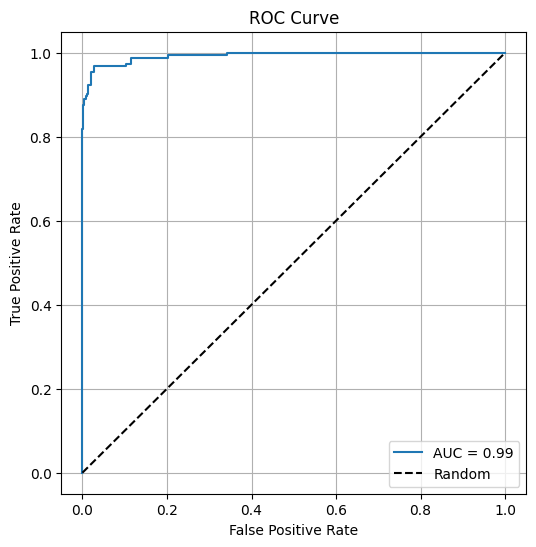

In [33]:
# Estimate class priors and proportions from the training data
priors = estimate_class_priors(Y_train)
theta = estimate_proportions(X_train, Y_train)

log_post = predict_log_proba(X_test, theta, priors)  # Now X_test is defined
predictions, spam_probs = classify(log_post, threshold=0.5)
TPR, FPR = evaluate_performance(Y_test, predictions)

print("True Positive Rate:", TPR)
print("False Positive Rate:", FPR)

draw_roc(Y_test, spam_probs)

### 4.5 Why did we use the Maximum a posteriori estimator rather than the maximum likelihood one?

MAP is preferred because it avoids assigning zero probability to unseen events, improves generalization, and adds a principled form of smoothing via prior beliefs.

## 5 - Extension of the model

One extension of the model is to consider a matrix of word counts instead of simply their presence/absence.
The model will change in various ways in this case:
   - We will count the total number of occurence in the spam or the ham set for each word.
   - the words are now considered to occur independently along the sentence (independent Multinoulli). Thus, for a document with k words $\mathbf{v}=(v_1,\ldots, v_k)$
    \begin{align}
    \mathbb{P}(\mathbf{v} \mid y = s)
  & =  \prod_{t=1}^{k} p_{v_t}
    \end{align}
       where $p_v$ is the probability to observe a word $v$
       
Note that with this new model we compute a product over the positions in the sentence while the bernoulli model did a product over all the words in the corpus.

1. Implement the estimation of parameters for this model and the computation of the posterior class probabilities. This question can be interpreted in different ways, please explain your choices.
2. Compare its accuracy and ROC curve with the previous model on a test set (*e.g.* go over section 3 and 4 again for this model).



5.1

In [34]:
## Multinomial NB Parameter Estimation
def estimate_multinomial_params(X, Y, alpha=1.0):
    """
    Estimate word probabilities for Multinomial NB

    """
    vocab_size = X.shape[1]
    spam_idx = np.where(Y == 'spam')[0]
    ham_idx = np.where(Y == 'ham')[0]

    # Total counts for each word in spam/ham
    spam_word_counts = X[spam_idx].sum(axis=0)
    ham_word_counts = X[ham_idx].sum(axis=0)

    # Total word counts in all spam/ham messages
    spam_total = spam_word_counts.sum()
    ham_total = ham_word_counts.sum()

    # Laplace-smoothed probabilities
    theta_spam = (spam_word_counts + alpha) / (spam_total + alpha * vocab_size)
    theta_ham = (ham_word_counts + alpha) / (ham_total + alpha * vocab_size)

    theta_mult = np.stack([theta_ham, theta_spam], axis=1)

    priors = {
        'ham': len(ham_idx) / len(Y),
        'spam': len(spam_idx) / len(Y)
    }

    return theta_mult, priors

## Compute Posterior with Multinomial Model
def predict_multinomial_log_proba(X, theta_mult, priors):
    """
    Compute log posterior using Multinomial NB

    """
    log_theta = np.log(theta_mult)
    log_priors = {
        'ham': np.log(priors['ham']),
        'spam': np.log(priors['spam'])
    }

    log_posts = []
    for x in X:
        log_lh_ham = x @ log_theta[:, 0]
        log_lh_spam = x @ log_theta[:, 1]
        log_posts.append([log_lh_ham + log_priors['ham'],
                          log_lh_spam + log_priors['spam']])

    return np.array(log_posts)



True Positive Rate: 0.922077922077922
False Positive Rate: 0.01040582726326743


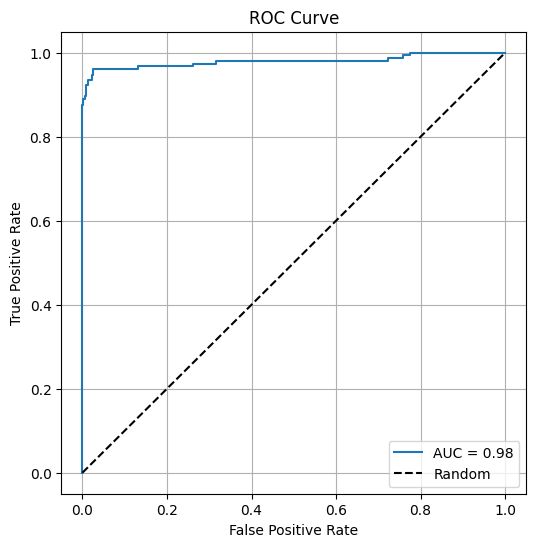

In [35]:
## Evaluation & ROC Curve

# Call estimate_multinomial_params to get theta_mult and update priors
theta_mult, priors = estimate_multinomial_params(X_train, Y_train)

log_posts = predict_multinomial_log_proba(X_test, theta_mult, priors)
preds, probs_spam = classify(log_posts, threshold=0.5)

TPR, FPR = evaluate_performance(Y_test, preds)

print("True Positive Rate:", TPR)
print("False Positive Rate:", FPR)

draw_roc(Y_test, probs_spam)

### 5.2

Bernoulli NB Accuracy: 0.9776, AUC: 0.9928
Multinomial NB Accuracy: 0.9803, AUC: 0.9797


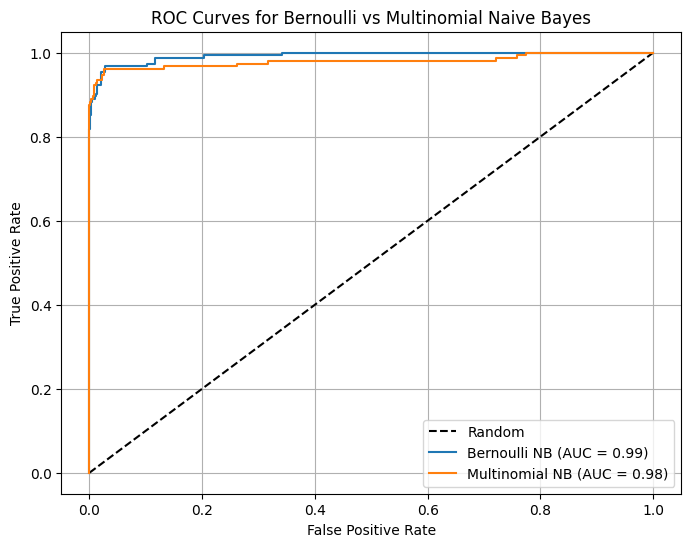

In [38]:
def evaluate_model(y_true, y_scores, y_pred, model_name=''):
    """
    Evaluates a model's performance using accuracy and AUC.
    Plots the ROC curve for the model.

    """
    acc = accuracy_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve([1 if y == 'spam' else 0 for y in y_true], y_scores)
    roc_auc = auc(fpr, tpr)

    print(f"{model_name} Accuracy: {acc:.4f}, AUC: {roc_auc:.4f}")

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    return acc, roc_auc

# Get predictions and probabilities for both models

log_post_bernoulli = predict_log_proba(X_test, theta, priors)
bernoulli_preds, bernoulli_probs = classify(log_post_bernoulli, threshold=0.5)

log_post_multinomial = predict_multinomial_log_proba(X_test, theta_mult, priors)
multinomial_preds, multinomial_probs = classify(log_post_multinomial, threshold=0.5)

# Plot ROC curves and calculate AUC
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'k--', label='Random')
evaluate_model(Y_test, bernoulli_probs, bernoulli_preds, "Bernoulli NB")
evaluate_model(Y_test, multinomial_probs, multinomial_preds, "Multinomial NB")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Bernoulli vs Multinomial Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()